# Setup

In [3]:
from helpers import make_data, score_iou

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
def preprocess_image(img):
    return np.where(img >= NOISE_LEVEL, img, 0.0)

# Dataset

In [5]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

In [6]:
class ClassificationDataset(Dataset):
    def __init__(self, N, **kwargs):
        self.N = N
        self.kwargs = kwargs
    
    def __len__(self):
        return self.N

    def __getitem__(self, index):
        if index >= self.N:
            raise StopIteration

        image, label = make_data(**self.kwargs)
        image = preprocess_image(image)
        label = 0 if np.any(np.isnan(label)) else 1
        return np.float32(image), np.float32(label)

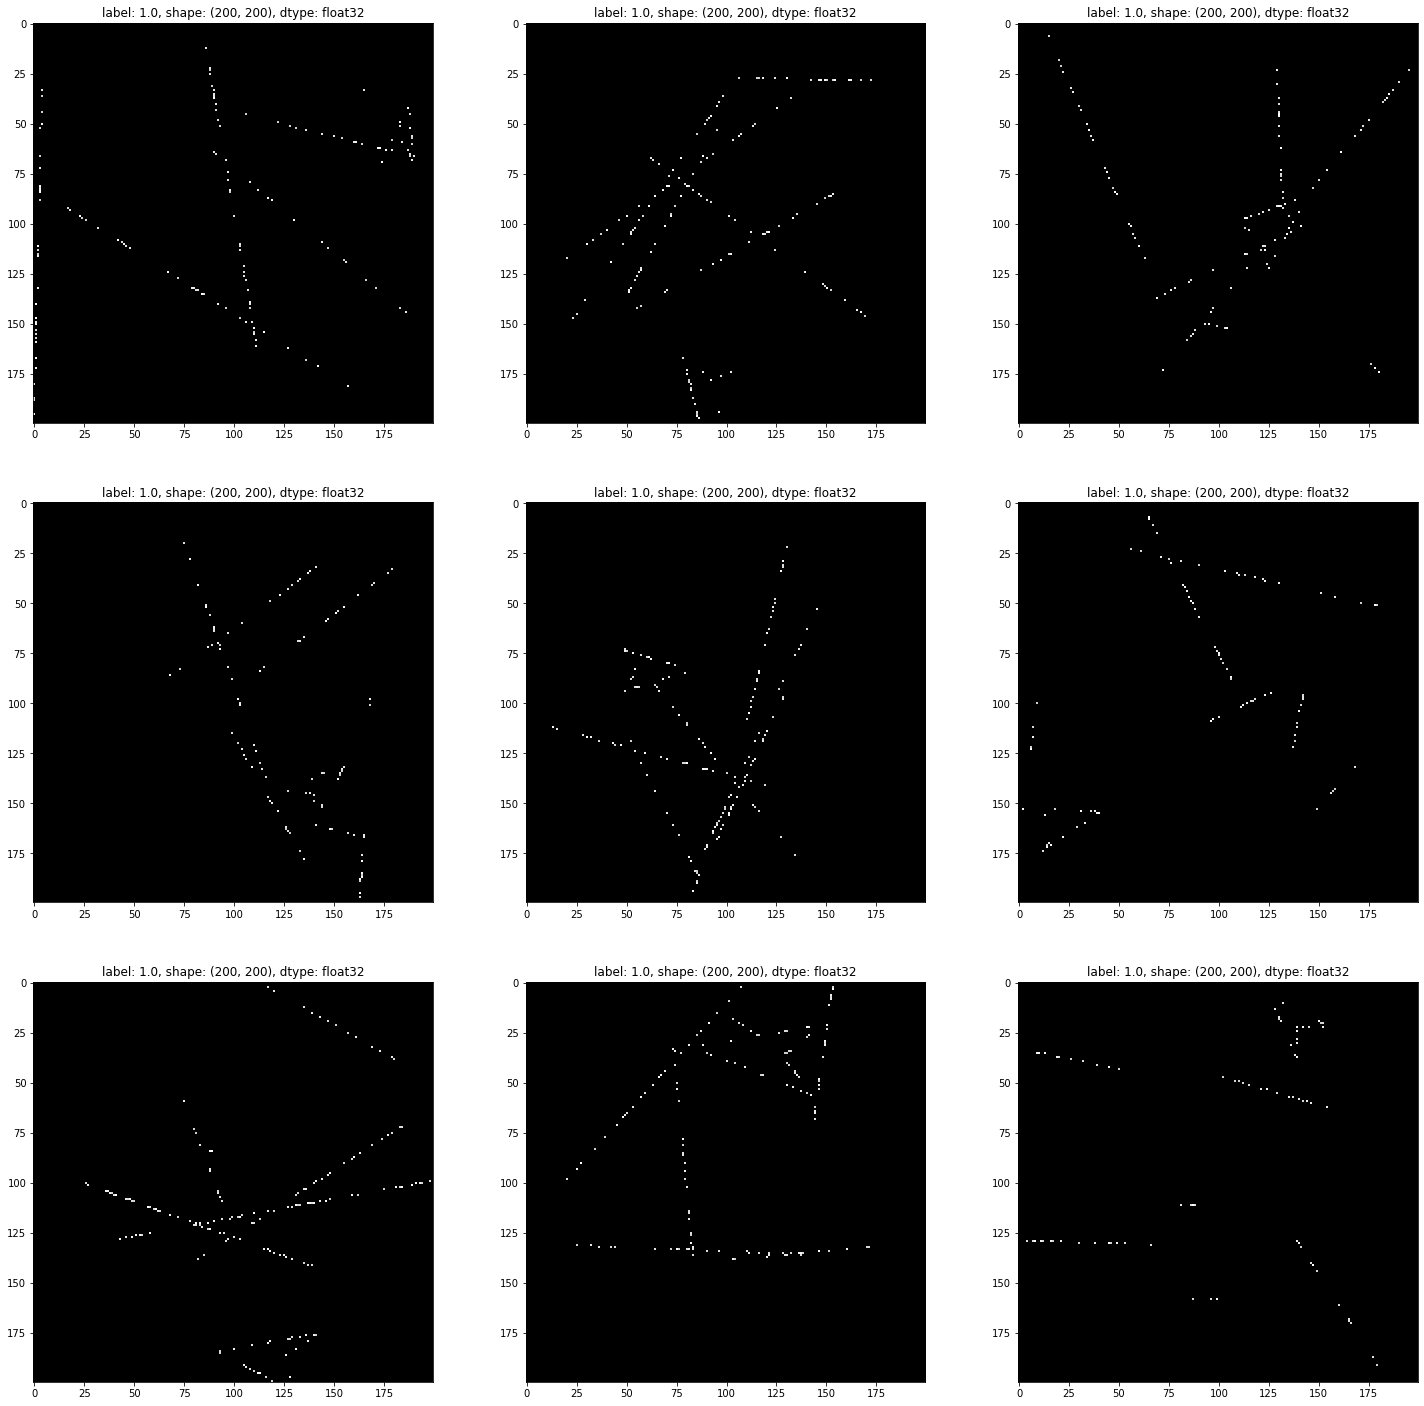

In [7]:
dataset = ClassificationDataset(9)

fig, ax = plt.subplots(3, 3, figsize=(25, 25))
for i, (image, label) in enumerate(dataset):
    ax[i//3][i%3].imshow(image, cmap="gray")
    ax[i//3][i%3].set_title(f"label: {label}, shape: {image.shape}, dtype: {image.dtype}")

# Data Module

In [8]:
class DataModule(pl.LightningDataModule):
    def __init__(self, n_train_examples, n_val_examples, batch_size):
        super().__init__()
        self.n_train_examples = n_train_examples
        self.n_val_examples = n_val_examples
        self.batch_size = batch_size

    def setup(self, stage):
        if stage == "fit":
            self.train_dataset = ClassificationDataset(self.n_train_examples)
            self.val_dataset = ClassificationDataset(self.n_val_examples)
        else:
            self.test_dataset = ClassificationDataset(self.n_val_examples)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [9]:
dm = DataModule(10000, 1000, 64)
dm.setup("fit")

for batch in dm.train_dataloader():
    images, labels = batch
    print(type(images), images.dtype, images.shape)
    print(type(images), images.dtype, images.unsqueeze(1).shape)
    print(type(labels), images.dtype, labels.shape)
    break

<class 'torch.Tensor'> torch.float32 torch.Size([64, 200, 200])
<class 'torch.Tensor'> torch.float32 torch.Size([64, 1, 200, 200])
<class 'torch.Tensor'> torch.float32 torch.Size([64])


# Model

In [10]:
class ClassificationModel(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.model = self.init_model()
        self.criterion = torch.nn.BCELoss()
        self.accuracy = pl.metrics.Accuracy()

    def init_model(self):
        model = torch.nn.Sequential()
        
        in_channels = 1
        conv_layers_params = [(8, 11), (16, 9), (32, 7), (64, 5), (128, 3)]
        for i, (nfilters, kernel_size) in enumerate(conv_layers_params):
            model.add_module(
                f"conv2d_{i}",
                torch.nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=nfilters,
                    kernel_size=kernel_size,
                    padding=(kernel_size - 1) // 2  # same padding, stride and dilation must be 1
                ),
            )
            model.add_module(f"relu_{i}", torch.nn.ReLU())
            model.add_module(f"max_pool_2d_{i}", torch.nn.MaxPool2d(2, 2))
            model.add_module(
                f"batch_normalization_{i}", 
                torch.nn.BatchNorm2d(nfilters, eps=0.001, momentum=0.01)
            )
            in_channels = nfilters

        model.add_module("flatten", torch.nn.Flatten())
        model.add_module("linear", torch.nn.Linear(4608, 1))
        model.add_module(f"sigmoid", torch.nn.Sigmoid())

        return model

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, images):
        images = images.unsqueeze(1)
        outputs = self.model(images)
        outputs = outputs.squeeze()
        return outputs

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
        loss = self.criterion(outputs, labels)
        acc = self.accuracy(outputs, labels)

        self.log("loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch):
        images, labels = batch
        outputs = self.forward(images)
        loss = self.criterion(outputs, labels)
        acc = self.accuracy(outputs, labels)

        self.log("loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

In [11]:
model = ClassificationModel().cuda()

print(model)
summary(model, (200, 200), device="cuda")

ClassificationModel(
  (model): Sequential(
    (conv2d_0): Conv2d(1, 8, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
    (relu_0): ReLU()
    (max_pool_2d_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_normalization_0): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv2d_1): Conv2d(8, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (relu_1): ReLU()
    (max_pool_2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_normalization_1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv2d_2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu_2): ReLU()
    (max_pool_2d_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_normalization_2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv2d_3): Conv2d(32, 64, 

# Main

In [12]:
dm = DataModule(8000, 1024, 8)

model = ClassificationModel()
model.cuda()

print(model)
summary(model, (200, 200), device="cuda")

ClassificationModel(
  (model): Sequential(
    (conv2d_0): Conv2d(1, 8, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
    (relu_0): ReLU()
    (max_pool_2d_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_normalization_0): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv2d_1): Conv2d(8, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (relu_1): ReLU()
    (max_pool_2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_normalization_1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv2d_2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu_2): ReLU()
    (max_pool_2d_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_normalization_2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv2d_3): Conv2d(32, 64, 

In [14]:
# # find ideal lr
# trainer = pl.Trainer(auto_lr_find=True, gpus=1)
# trainer.tune(model, dm)

In [13]:
trainer = pl.Trainer(
    max_epochs=60,
    gpus=1,
    progress_bar_refresh_rate=20,
    # default_root_dir="somethingsomething"
)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name      | Type       | Params
-----------------------------------------
0 | model     | Sequential | 166 K 
1 | criterion | BCELoss    | 0     
2 | accuracy  | Accuracy   | 0     
-----------------------------------------
166 K     Trainable params
0         Non-trainable params
166 K     Total params


1

In [14]:
preds, targets = [], []
for images, labels in tqdm(dm.val_dataloader()):
    outputs = model.forward(images)
    preds.extend([round(float(x)) for x in outputs])
    targets.extend([round(float(x)) for x in labels])

100%|██████████| 128/128 [00:34<00:00,  3.67it/s]


In [16]:
from sklearn.metrics import classification_report
print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       233
           1       0.98      0.99      0.98       791

    accuracy                           0.97      1024
   macro avg       0.97      0.96      0.96      1024
weighted avg       0.97      0.97      0.97      1024

